In [1]:
from astropy.io import fits
from astropy.table import Table
import matplotlib.pyplot as plt
import numpy as np
import math
import random
import pickle
import os
import time

%matplotlib inline
import matplotlib as mpl
from matplotlib import pyplot as plt
# better-looking plots
plt.rcParams['font.family'] = 'serif'
plt.rcParams['figure.figsize'] = (10.0, 8)
plt.rcParams['font.size'] = 18
mpl.ticker.AutoLocator.default_params['nbins'] = 5
mpl.ticker.AutoLocator.default_params['prune'] = 'both'

mpl.rcParams['ps.useafm'] = True
mpl.rcParams['pdf.use14corefonts'] = True
mpl.rcParams['text.usetex'] = True

from palettable.colorbrewer.sequential import Greys_9
from scipy.optimize import curve_fit

In [2]:
os.chdir('../Debiasing/')

In [3]:
import make_dictionaries
questions = make_dictionaries.questions
sample = Table.read('../fits/full_sample_debiased.fits')
print('Loaded galaxy data...')
a40 = Table.read('../fits/ALFALFA/a40.csv')
a40_reference = Table.read('../fits/ALFALFA/a40_ref.csv')
print('Loaded ALFALFA-40 data.')

Loaded galaxy data...
Loaded ALFALFA-40 data.


In [9]:
# First need to match the AGC numbers:

def find_matches(list1,list2):
    match_values = set(list1).intersection(list2) # matches
    match_array = np.zeros((len(match_values),2))
    for i,m in enumerate(match_values):
        match_array[i,0] = np.where(np.in1d(list1,m))[0]
        match_array[i,1] = np.where(np.in1d(list2,m))[0]
    
    return match_array.astype(int)

a40_matches = find_matches(a40['AGCNr'],a40_reference['AGCNr'])
a40 = a40[a40_matches[:,0]]
a40_reference = a40_reference[a40_matches[:,1]]

In [10]:
# Same redshift cut as Masters+ AlFALFA bars paper.

in_volume_limit = ((sample['REDSHIFT_1'] <= 0.05) 
                   & (sample['REDSHIFT_1'] >= 0.03)
                   & (sample['PETROMAG_MR'] <= -19.78)) # lims. of the new vls.


def get_spiral_sample(data,questions,in_volume_limit=None,in_mass_limit=None,printout=True,p_th=None):
    
    if in_volume_limit == None:
        in_volume_limit = np.ones(len(data))
        
    select_p = (data['t01_smooth_or_features_a02_features_or_disk_debiased_rh']
                *data['t02_edgeon_a05_no_debiased_rh']*data['t04_spiral_a08_spiral_debiased_rh']) > 0.5
    select_N = (data['t04_spiral_a08_spiral_count'] - data['t11_arms_number_a37_cant_tell_count']) >= 5
    
    if in_mass_limit == None:
        select = (in_volume_limit) & (select_p) & (select_N)
    else:
        select = (in_volume_limit) & (select_p) & (select_N) & (in_mass_limit)
        
    answers = questions['t11_arms_number']['answers'][:-1]
    arm_answers = ['t11_arms_number_' + A + '_debiased_rh' for A in answers]
    arm_array = np.array([data[A] for A in arm_answers]).T
    arm_assignments = np.argmax(arm_array,axis=1)
    if p_th != None:
        p_values = np.max(arm_array,axis=1)
        arm_assignments[p_values < p_th] = -999
        
    if printout:
        print('{}/{} selected'.format(np.sum(select),len(select)))
        for m in range(5):
            print('m={}: {}/{} spiral galaxies selected'.format(m+1,np.sum(arm_assignments[select] == m)
                                                         ,len(arm_assignments[select] == m)))
    
    return select,arm_assignments

In [11]:
select_spirals,m_values = get_spiral_sample(sample,questions,in_volume_limit)

8205/228201 selected
m=1: 446/8205 spiral galaxies selected
m=2: 5253/8205 spiral galaxies selected
m=3: 1324/8205 spiral galaxies selected
m=4: 506/8205 spiral galaxies selected
m=5: 676/8205 spiral galaxies selected


/home/ppxrh/anaconda3/lib/python3.4/site-packages/ipykernel/__main__.py:10: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
/home/ppxrh/anaconda3/lib/python3.4/site-packages/ipykernel/__main__.py:14: RuntimeWarning: invalid value encountered in greater


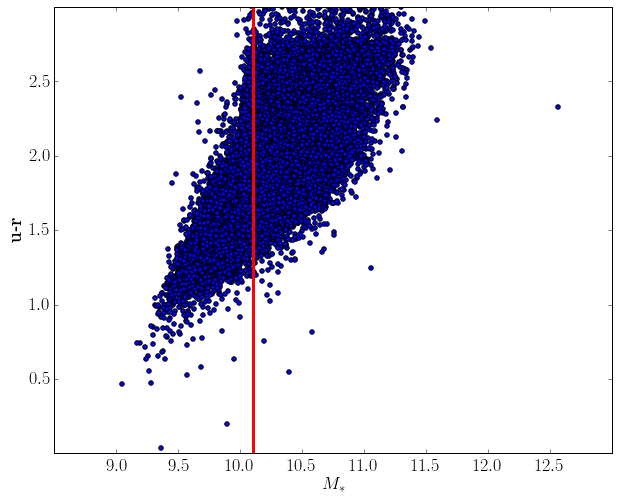

In [12]:
vl_sample = sample[in_volume_limit]
plt.scatter(vl_sample['LOGMSTAR_BALDRY06'],vl_sample['PETROMAG_MU']-vl_sample['PETROMAG_MR'])
_ = plt.ylim(0,3)
plt.vlines(10.1,0,3,color='r',linewidth=3)

plt.xlabel('$M_*$')
plt.ylabel('u-r')

in_mass_limit = sample['LOGMSTAR_BALDRY06'] >= 10.1 # new value (from plot below)

In [13]:
# How many galaxies are in the ALFALFA region?
import astropy.units as u
import astropy.coordinates as coord

ra_min = coord.ICRS(ra=7.5,dec=10,unit=(u.hourangle, u.degree))
ra_max = coord.ICRS(ra=16.5,dec=10,unit=(u.hourangle,u.degree))
ra_limits = [ra_min.ra.deg,ra_max.ra.deg]

select_ra = (sample['ra_1'] >= ra_limits[0]) & (sample['ra_1'] <= ra_limits[1])
select_dec1 = (sample['dec_1'] >= 4) & (sample['dec_1'] <= 16)
select_dec2 = (sample['dec_1'] >= 24) & (sample['dec_1'] <= 28)
select_dec = [any(s) for s in zip(select_dec1,select_dec2)]
select_spatial = (select_ra) & (select_dec)

print('{}/{} of SDSS in the ALFALFA-40 coverage'.format(np.sum(select_spatial),len(select_spatial))
      + ' ({0:.1f}%)'.format(np.sum(select_spatial)/len(select_spatial)*100))

61430/228201 of SDSS in the ALFALFA-40 coverage (26.9%)


In [16]:
# Match ALFALFA-40 to our samples?

vl_spirals = sample[(in_volume_limit) & (select_spirals)]
ml_spirals = sample[(in_volume_limit) & (select_spirals) & (in_mass_limit)]
vl_m = m_values[(in_volume_limit) & (select_spirals)]
ml_m = m_values[(in_volume_limit) & (select_spirals) & (in_mass_limit)]
print('Luminosity-limited: {} galaxies \nStellar mass-limited: {} galaxies'.format(len(vl_spirals),len(ml_spirals)))

vl_matches = find_matches(vl_spirals['dr7objid_1'],a40_reference['PhotoObjID'])
print('---> {} matched in the luminosity-limited sample'.format(len(vl_matches)) 
      + ' ({0:.1f}%)'.format(len(vl_matches)/len(vl_spirals)*100))
ml_matches = find_matches(ml_spirals['dr7objid_1'],a40_reference['PhotoObjID'])
print('---> {} matched in the stellar mass-limited sample'.format(len(ml_matches))
      + ' ({0:.1f}%)'.format(len(ml_matches)/len(ml_spirals)*100))

Luminosity-limited: 8205 galaxies 
Stellar mass-limited: 5359 galaxies
---> 1436 matched in the luminosity-limited sample (17.5%)
---> 926 matched in the stellar mass-limited sample (17.3%)


In [17]:
from scipy.stats import binned_statistic
import scipy.stats.distributions as dist

def bin_by_column(column, nbins, fixedcount=True):
    sorted_indices = np.argsort(column)
    if fixedcount:
        bin_edges = np.linspace(0, 1, nbins + 1)
        bin_edges[-1] += 1
        values = np.empty(len(column))
        values[sorted_indices] = np.linspace(0, 1, len(column))
        bins = np.digitize(values, bins=bin_edges)
    else:
        bin_edges = np.linspace(np.min(column),np.max(column), nbins + 1)
        bin_edges[-1] += 1
        values = column
        bins = np.digitize(values, bins=bin_edges)
    x, b, n = binned_statistic(values, column, bins=bin_edges)
    return x, bins


def get_fractions(column,bins,th=0.5):
    
    fracs = np.zeros(len(np.unique(bins)))
    
    for m,b in enumerate(np.unique(bins)):
        
        bin_data = column[bins == b]
        fracs[m] = np.sum(bin_data > th)/len(bin_data)
        
    return fracs


def plot_by_column(x_column,y_column,color='k',label='___',nbins=10):

    x,bins = bin_by_column(x_column,nbins=nbins)
    x = []
    x_error = []
    y = []
    y_error = []

    for b in np.unique(bins):
    
        x.append(np.mean(x_column[bins == b]))
        x_error.append(np.std(x_column[bins == b]/np.sqrt(len(x_column[bins == b]))))
        y.append(np.mean(y_column[bins == b]))
        y_error.append(np.std(y_column[bins == b]/np.sqrt(len(y_column[bins == b]))))
        
    plt.errorbar(x,y,xerr=x_error,yerr=y_error,fmt='o',color=color,linewidth=2,label=label)
    
    return None


def get_fractional_errors(k,n,c=0.683):
    
    p_lower = dist.beta.ppf((1-c)/2.,k+1,n-k+1)
    p_upper = dist.beta.ppf(1-(1-c)/2.,k+1,n-k+1)
    
    return p_lower,p_upper


def get_arm_fraction(column,bins,m):
    
    N_b = len(np.unique(bins))
    fractions = np.zeros(N_b)
    upper_fracs = np.zeros(N_b)
    lower_fracs = np.zeros(N_b)
    
    for n,b in enumerate(np.unique(bins)):
        
        bin_col = column[bins == b]
        bin_m = np.sum(bin_col == m)
        bin_tot = len(bin_col)
        
        f_low,f_high = get_fractional_errors(bin_m,bin_tot)
        fractions[n] = bin_m/bin_tot
        lower_fracs[n] = f_low
        upper_fracs[n] = f_high
    
    fractions_table = Table(np.array([lower_fracs,fractions,upper_fracs]).T
                            ,names=('low_f','f','high_f'))
    
    return fractions_table


def plot_by_column_abs(x_column,assignments,color='k',label='___',nbins=10,m_vals=[2]):
    
    x,bins = bin_by_column(x_column,nbins=nbins)
    
    n = []
    k = []
    
    for b in np.unique(bins):
        
        a_b = assignments[bins == b]
        in_m = a_b == 1000
        for m in m_vals:
            in_m = in_m + (a_b == m)
        k.append(len(a_b))
        n.append(np.sum(in_m))
        
    n = np.array(n)
    k = np.array(k)
    
    fractions = np.zeros(len(n))
    upper_fracs = np.zeros(len(n))
    lower_fracs = np.zeros(len(n))
    
    f = n/k
    f_low,f_high = get_fractional_errors(n,k)
    lower_fracs = f_low
    upper_fracs = f_high
        
    plt.errorbar(x,f,yerr=[f-f_low,f_high-f],fmt='o',color=color,linewidth=2,label=label)
    
    return None

In [18]:
matched_galaxies = ml_spirals[ml_matches[:,0]]
matched_a40 = a40[ml_matches[:,1]]
matched_a40_reference = a40_reference[ml_matches[:,1]]
matched_m = ml_m[ml_matches[:,0]]
bar_values = np.argmax(np.array([matched_galaxies['t03_bar_' + a + '_debiased_rh'] 
                                 for a in ['a06_bar','a07_no_bar']]).T,axis=1)

log_fgas = (matched_a40['logMsun'] - matched_galaxies['LOGMSTAR_BALDRY06'])
fgas = 10**log_fgas

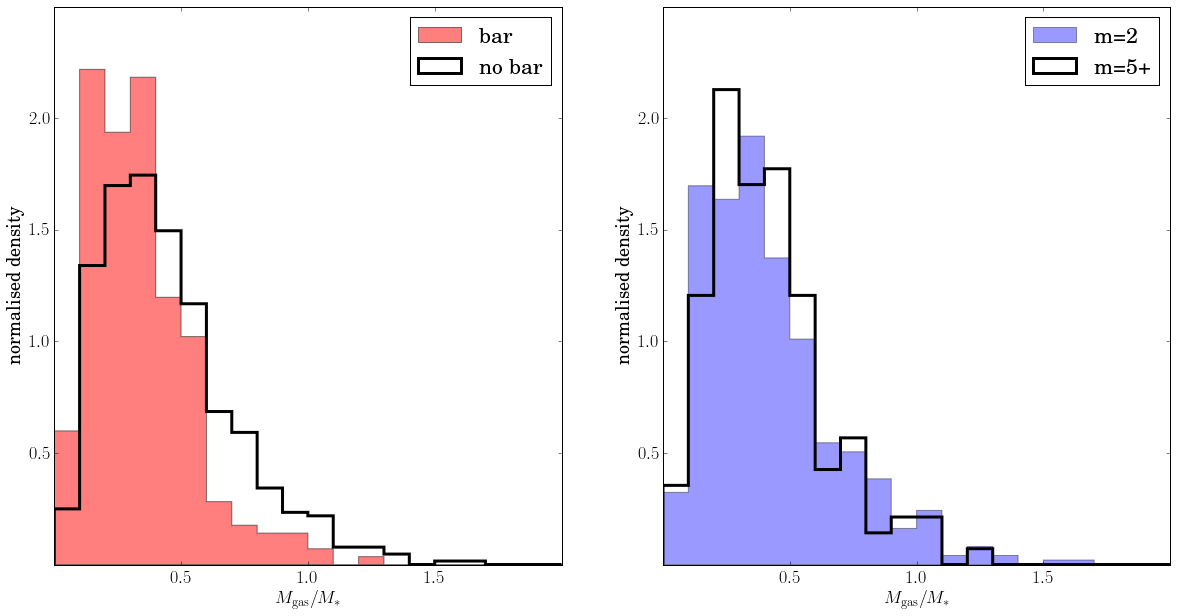

In [19]:
fig,axarr = plt.subplots(1,2,figsize=(20,10))
bins = np.linspace(0,2,21)

plt.sca(axarr[0])
_ = plt.hist(fgas[bar_values == 0],bins=bins,normed=True,
             histtype='stepfilled',color='r',alpha=0.5,label='bar')
_ = plt.hist(fgas[bar_values == 1],bins=bins,normed=True,
             histtype='step',lw=3,color='k',label='no bar')
plt.xlabel('$M_{\mathrm{gas}}/M_*$')
plt.ylabel('normalised density')
_ = plt.legend()

plt.sca(axarr[1])
_ = plt.hist(fgas[matched_m == 1],bins=bins,normed=True,
             histtype='stepfilled',color='b',alpha=0.4,label='m=2')
_ = plt.hist(fgas[matched_m == 4],bins=bins,normed=True,
             histtype='step',lw=3,color='k',label='m=5+')
plt.xlabel('$M_{\mathrm{gas}}/M_*$')
plt.ylabel('normalised density')
_ = plt.legend()

In [20]:
def plot_by_column(x_column,y_column,color='k',label='___',nbins=10,logx=False,logy=False):
    
    if logx:
        x_column = np.log10(x_column)
    if logy:
        y_column = np.log10(y_column)
        
    select_finite = (np.isfinite(x_column)) & (np.isfinite(y_column))
    x_column = x_column[select_finite]
    y_column = y_column[select_finite]

    x,bins = bin_by_column(x_column,nbins=nbins)
    x = []
    x_error = []
    y = []
    y_error = []

    for b in np.unique(bins):
    
        x.append(np.mean(x_column[bins == b]))
        x_error.append(np.std(x_column[bins == b]/np.sqrt(len(x_column[bins == b]))))
        y.append(np.mean(y_column[bins == b]))
        y_error.append(np.std(y_column[bins == b]/np.sqrt(len(y_column[bins == b]))))
        
    plt.errorbar(x,y,xerr=x_error,yerr=y_error,fmt='o',color=color,linewidth=2,label=label)
    
    return None


def plot_2xy(ax,col1,col2,label1='f1',label2='f2',legend=True,nbins=8,logx=False,logy=False):
    
    plt.sca(ax)
    _ = plot_by_column(col1,col2,label='{} vs. {}'.format(label1,label2),
                       color='b',nbins=nbins,logx=logx,logy=logy)
    _ = plot_by_column(col2,col1,label='{} vs. {}'.format(label2,label1),
                       color='r',nbins=nbins,logx=logx,logy=logy)
    
    if legend:
        _ = plt.legend(fontsize=15)
    if logx:
        plt.xlabel('$\log(f)$')
    else:
        plt.xlabel('$f$')
    if logy:
        plt.ylabel('$\log(f)$')
    else:
        plt.ylabel('$f$')
    
    return None

In [22]:
from sklearn.preprocessing import scale
from sklearn.cross_validation import KFold
from sklearn.neighbors.kde import KernelDensity
from astroML.linear_model import NadarayaWatson

def xyz_contour(x,y,z,xlabel='$f_2$',ylabel='$f_{\mathrm{bar}}$',zlabel='$\log(f_{\mathrm{gas}})$'
                ,h='minimise',cbar=True,plot_bandwidth=None,spacing=0.1):
    
    finite = (np.isfinite(x)) & (np.isfinite(y)) & (np.isfinite(z))
    x,y,z = [x[finite],y[finite],z[finite]]
    
    x_scaled,y_scaled = [scale(x),scale(y)]
    xy = np.array([x_scaled,y_scaled]).T
    
    x_grid_raw = np.linspace(np.min(x),np.max(x),100)
    y_grid_raw = np.linspace(np.min(y),np.max(y),100)
    
    x_grid = np.linspace(np.min(x_scaled),np.max(x_scaled),100)
    y_grid = np.linspace(np.min(y_scaled),np.max(y_scaled),100)
    x_g,y_g = np.array(np.meshgrid(x_grid,y_grid))
    xy_grid = np.array([x_g.ravel().squeeze(),y_g.ravel().squeeze()]).T
    
    if h == 'minimise':
        residuals,h_values = get_xyz_bandwidth(x_scaled,y_scaled,z)
        h = h_values[np.argmin(residuals)]
        print('best h found = {0:.2f}'.format(h))
    
    clf = NadarayaWatson('gaussian',h)
    clf.fit(xy,z)
    z_fit = clf.predict(xy_grid)

    plt.contourf(x_grid_raw,y_grid_raw,z_fit.reshape(100,100),
                 levels=np.linspace(np.min(z_fit),np.max(z_fit),1000),
                 cmap=Greys_9.mpl_colormap)
    
    plt.xlim(x_grid_raw[0],x_grid_raw[-1])
    plt.ylim(y_grid_raw[0],y_grid_raw[-1])

    if cbar:
        cb = plt.colorbar()
        cb.set_ticks(np.arange(-5,5,spacing))
        cb.set_label(zlabel)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    
    if plot_bandwidth != None:
        len_xb = h*np.std(x)/2
        len_yb = h*np.std(y)/2
        xmin,xmax = [x_grid_raw[0],x_grid_raw[-1]]
        ymin,ymax = [y_grid_raw[0],y_grid_raw[-1]]
        x_pos = xmin + 0.9*(xmax-xmin)
        y_pos = ymin + 0.9*(ymax-ymin)

        plt.hlines(y_pos,x_pos-len_xb,x_pos+len_xb,color=plot_bandwidth,lw=2)
        plt.vlines(x_pos,y_pos-len_yb,y_pos+len_yb,color=plot_bandwidth,lw=2)
    return None
        

def get_xyz_bandwidth(x,y,z,plot=False):
    
    xy = np.array([x,y]).T
    
    kf = KFold(n=len(x),n_folds=3,shuffle=True,random_state=0)
    h_arr = np.logspace(-1,1,20)
    def get_h_residual(h_arr,kf):
        residuals = []
        for h in h_arr:
            residual = []
            for train,test in kf:
                training_xy = xy[train]
                training_z = z[train]
                test_xy = xy[test]
                test_z = z[test]
                clf = NadarayaWatson('gaussian',h=h)
                clf.fit(training_xy, training_z)
                z_fit = clf.predict(test_xy)
                
                residual.append(np.sum((test_z - z_fit)**2))
            residuals.append(np.sum(residual))
        return residuals
    
    residuals = get_h_residual(h_arr,kf)
    if plot:
        plt.figure()
        plt.plot(h_arr,residuals,lw=2)
        plt.xlabel('h')
        plt.ylabel('$\Sigma \chi ^2$')
        
    h_arr_precise = np.linspace(h_arr[np.argmin(residuals)-1],h_arr[np.argmin(residuals)+1],20)
    residuals = get_h_residual(h_arr_precise,kf)
    if plot:
        plt.figure()
        plt.plot(h_arr_precise,residuals,lw=2)
        plt.xlabel('h')
        plt.ylabel('$\Sigma \chi ^2$')

    return residuals,h_arr_precise
        
###################################################

In [108]:
from sklearn.neighbors.kde import KernelDensity
from sklearn.grid_search import GridSearchCV

def xy_contour(x,y,xlabel='$f_2$',ylabel='$f_{\mathrm{bar}}$'
                ,h='minimise',plot_bandwidth=None,
               spacing=0.1,levels=[0.2,0.4,0.6,0.8],color='r'):
    
    finite = (np.isfinite(x)) & (np.isfinite(y))
    x,y = [x[finite],y[finite]]
    
    x_scaled,y_scaled = [scale(x),scale(y)]
    xy = np.array([x_scaled,y_scaled]).T
    
    x_grid_raw = np.linspace(np.min(x),np.max(x),100)
    y_grid_raw = np.linspace(np.min(y),np.max(y),100)
    
    x_grid = np.linspace(np.min(x_scaled),np.max(x_scaled),100)
    y_grid = np.linspace(np.min(y_scaled),np.max(y_scaled),100)
    x_g,y_g = np.array(np.meshgrid(x_grid,y_grid))
    xy_grid = np.array([x_g.ravel().squeeze(),y_g.ravel().squeeze()]).T
    
    if h == 'minimise':
        h = get_xy_bandwidth(xy)
        #h = h_values[np.argmin(residuals)]
        print('best h found = {0:.2f}'.format(h))
    
    clf = KernelDensity(kernel='gaussian',bandwidth=h).fit(xy)
    z_fit = np.exp(clf.score_samples(xy_grid).reshape(100,100))
    # Rest is taken from the triangle.py method of plotting fractional data contours.
    #--------------------------------------------------------------------------------
    Hflat = z_fit.flatten()
    inds = np.argsort(Hflat)[::-1]
    Hflat = Hflat[inds]
    sm = np.cumsum(Hflat)
    sm /= sm[-1]
    V = np.empty(len(levels))
    for i, v0 in enumerate(levels):
        try:
            V[i] = Hflat[sm <= v0][-1]
        except:
            V[i] = Hflat[0]
    # ------------------------------------------------------------------------------
    
    plt.contour(x_grid_raw,y_grid_raw,z_fit,levels=V,linewidths=2,colors=color,zorder=1)
    
    plt.xlim(x_grid_raw[0],x_grid_raw[-1])
    plt.ylim(y_grid_raw[0],y_grid_raw[-1])
    
    if plot_bandwidth != None:
        len_xb = h*np.std(x)/2
        len_yb = h*np.std(y)/2
        xmin,xmax = [x_grid_raw[0],x_grid_raw[-1]]
        ymin,ymax = [y_grid_raw[0],y_grid_raw[-1]]
        x_pos = xmin + 0.9*(xmax-xmin)
        y_pos = ymin + 0.9*(ymax-ymin)

        plt.hlines(y_pos,x_pos-len_xb,x_pos+len_xb,color=plot_bandwidth,linewidths=2)
        plt.vlines(x_pos,y_pos-len_yb,y_pos+len_yb,color=plot_bandwidth,linewidths=2)
    return None


def get_xy_bandwidth(xy_grid):
    
    params = {'bandwidth': np.logspace(-1,0.3,100)}
    kf = KFold(n=len(xy_grid),n_folds=3,shuffle=True,random_state=0)
    grid = GridSearchCV(KernelDensity(), params,cv=kf)
    grid.fit(xy_grid)
    
    return grid.best_estimator_.bandwidth 

In [24]:
x = f2
y = fbar
z = fgas

#colour_contour(x,y,z,plot_bandwidth=True)

def cycle_3_parameters(a,b,c,a_label='a',b_label='b',c_label='c'):
    
    fig,axarr = plt.subplots(1,3,figsize=(20,6.7))
    plt.sca(axarr[0])
    xyz_contour(a,b,c,plot_bandwidth=None,
                xlabel=a_label,ylabel=b_label,zlabel=c_label)
    xy_contour(a,b,levels=[0.67,0.95])
    plt.sca(axarr[1])
    xyz_contour(b,c,a,plot_bandwidth=None,
                xlabel=b_label,ylabel=c_label,zlabel=a_label)
    xy_contour(b,c,levels=[0.67,0.95])
    plt.sca(axarr[2])
    xyz_contour(c,a,b,plot_bandwidth=None,
                xlabel=c_label,ylabel=a_label,zlabel=b_label)
    xy_contour(c,a,levels=[0.67,0.95])
    
    plt.tight_layout()
    
    return None

best h found = 0.50
best h found = 0.11
best h found = 0.65
best h found = 0.19
best h found = 0.47
best h found = 0.19


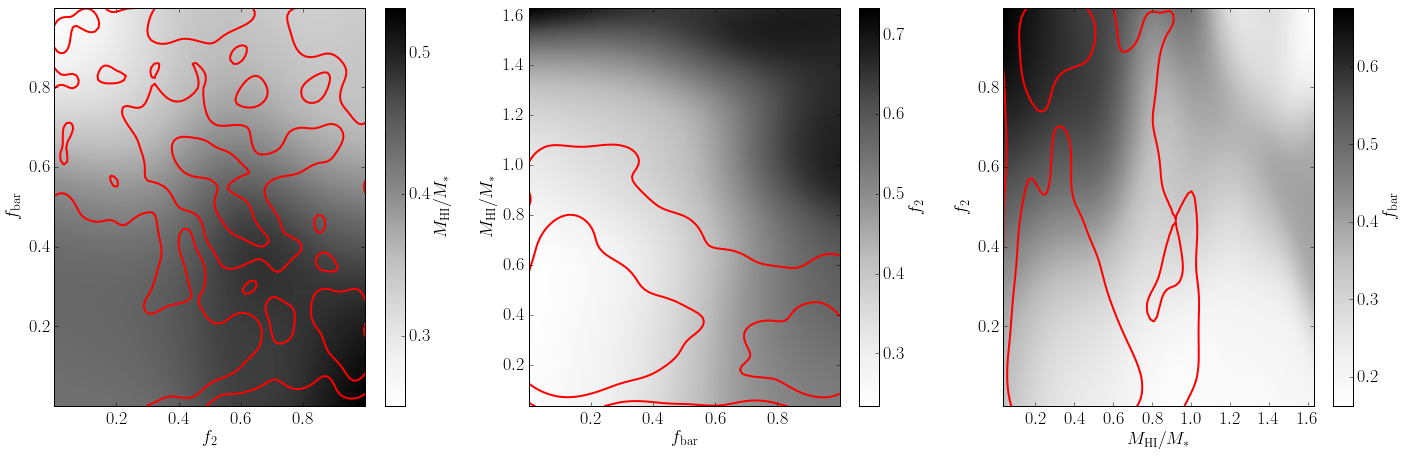

In [25]:
cycle_3_parameters(x,y,z,'$f_{\mathrm{2}}$','$f_{\mathrm{bar}}$','$M_{\mathrm{HI}}/M_*$')

best h found = 0.51
best h found = 0.19


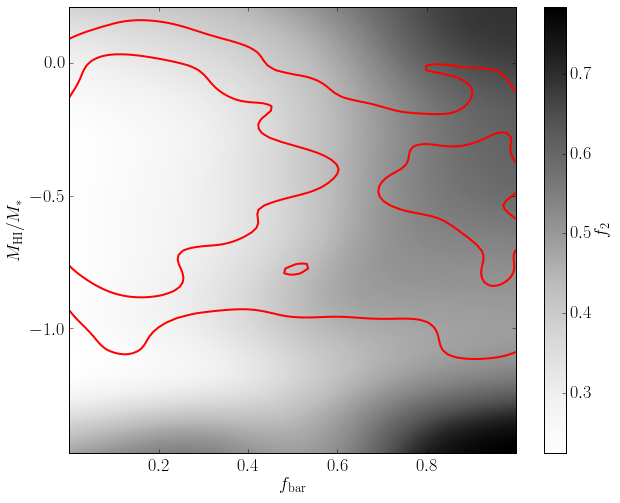

In [26]:
plt.figure(figsize=(10,8))
a = fbar
b = np.log10(fgas)
c = f2
a_label = '$f_{\mathrm{bar}}$'
b_label = '$M_{\mathrm{HI}}/M_*$'
c_label = '$f_{\mathrm{2}}$'

xyz_contour(a,b,c,plot_bandwidth=None,
            xlabel=a_label,ylabel=b_label,zlabel=c_label)
xy_contour(a,b,levels=[0.68,0.95],color='r')
#_ = plt.scatter(a,b,color='k',zorder=2)

In [27]:
Q = 't11_arms_number'
col_labels = questions[Q]['answers'][:-1]

arm_array = np.array([matched_galaxies[Q + '_' + A + '_debiased_rh'] for A in col_labels]).T

p4_5 = (arm_array[:,3] + arm_array[:,4])/np.sum(arm_array,axis=1)

best h found = 0.64
best h found = 0.19


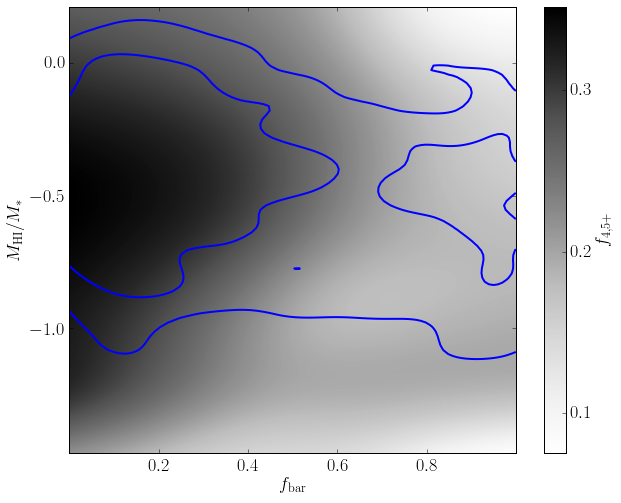

In [28]:
plt.figure(figsize=(10,8))
a = fbar
b = np.log10(fgas)
c = p4_5
a_label = '$f_{\mathrm{bar}}$'
b_label = '$M_{\mathrm{HI}}/M_*$'
c_label = '$f_{\mathrm{4,5+}}$'

xyz_contour(a,b,c,plot_bandwidth=None,
            xlabel=a_label,ylabel=b_label,zlabel=c_label)
xy_contour(a,b,levels=[0.68,0.95],color='b')

y=-0.66x + 6.44


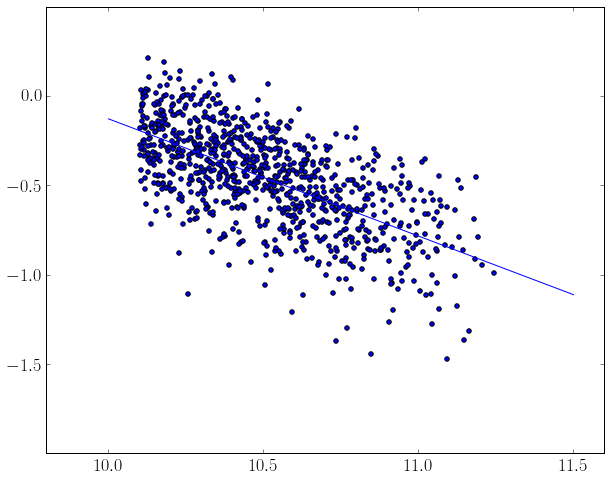

In [88]:
# Gas 'deficiency'
from scipy.optimize import minimize

mass = matched_galaxies['LOGMSTAR_BALDRY06']
colour = matched_galaxies['PETROMAG_MR'] - matched_galaxies['PETROMAG_MI']

x_guide = np.linspace(10,11.5,10)

data = np.array([mass.data,log_fgas.data]).T

def linear(x,m,c):
    y = m*x + c
    return y

popt,pcov = curve_fit(linear,data[:,0],data[:,1])
_ = plt.scatter(data[:,0],data[:,1])
_ = plt.plot(x_guide,linear(x_guide,*popt))
print('y={0:.2f}x'.format(popt[0]) + ' + {0:.2f}'.format(popt[1]))

In [115]:
# First define the set of parameters:

mass = matched_galaxies['LOGMSTAR_BALDRY06']
log_fgas = (matched_a40['logMsun'] - matched_galaxies['LOGMSTAR_BALDRY06'])
fgas = 10**log_fgas

log_fgas_expected = mass*popt[0] + popt[1]

gas_deficiency = log_fgas -log_fgas_expected
local_density = matched_galaxies['IVAN_DENSITY']

In [98]:
def get_p(sample,question,answer,questions,exclude=False):
    
    answers = questions[question]['answers']
    if exclude:
        answers = answers[:-1]
    
    m = np.array([sample[question + '_' + A + '_debiased_rh'] for A in answers]).T
    p = m[:,answer]/np.sum(m,axis=1)
    return p

In [104]:
p_2 = get_p(matched_galaxies,'t11_arms_number',1,questions,True)
p_4 = get_p(matched_galaxies,'t11_arms_number',3,questions,True)
p_5 = get_p(matched_galaxies,'t11_arms_number',4,questions,True)

p_floc = p_4 + p_5
p_bar = get_p(matched_galaxies,'t03_bar',0,questions)

best h found = 0.74
best h found = 0.18


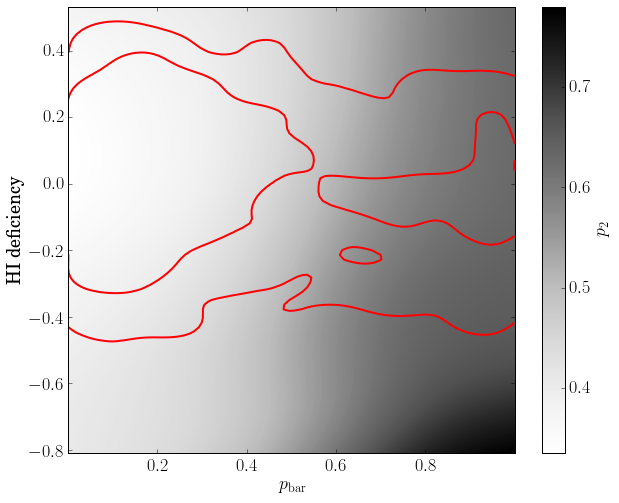

In [110]:
a = p_bar
b = gas_deficiency
c = p_2
a_label = '$p_{\mathrm{bar}}$'
b_label = 'HI deficiency'
c_label = '$p_{\mathrm{2}}$'

xyz_contour(a,b,c,plot_bandwidth=None,
            xlabel=a_label,ylabel=b_label,zlabel=c_label)
xy_contour(a,b,levels=[0.68,0.95],color='r')

best h found = 0.83
best h found = 0.18


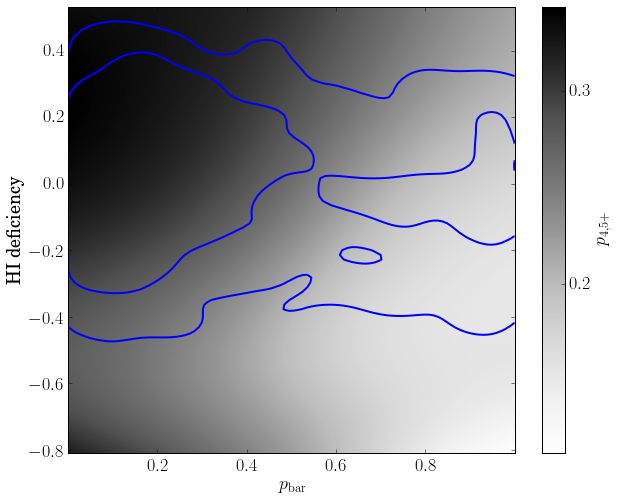

In [111]:
a = p_bar
b = gas_deficiency
c = p_floc
a_label = '$p_{\mathrm{bar}}$'
b_label = 'HI deficiency'
c_label = '$p_{\mathrm{4,5+}}$'

xyz_contour(a,b,c,plot_bandwidth=None,
            xlabel=a_label,ylabel=b_label,zlabel=c_label)
xy_contour(a,b,levels=[0.68,0.95],color='b')

In [195]:
from sklearn.decomposition import PCA

input_array = np.array([p_2,gas_deficiency,p_bar,local_density]).T

pca = PCA(n_components=2).fit(input_array)
print('PCA analysis:')
#print(pca.components_)
#print(pca.explained_variance_ratio_)
print(".'. {0:.1f}% along a single axis?".format(pca.explained_variance_ratio_[0]*100))

print(pca.components_[0]/pca.components_[0,0])

'''
print('Covariance matrix:')
_ = np.cov(input_array.T)
print(_)
'''

PCA analysis:
.'. 51.7% along a single axis?
[  1.          -1.73937939   0.76848664  14.71577474]


"\nprint('Covariance matrix:')\n_ = np.cov(input_array.T)\nprint(_)\n"

PCA analysis:
[[ 0.66227085  0.74926452]
 [ 0.74926452 -0.66227085]]
[ 0.93535032  0.06464968]


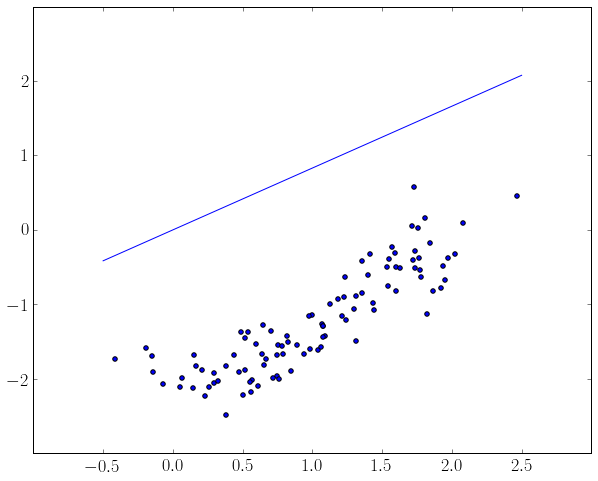

In [213]:
x = np.linspace(0,2,100) + np.random.randn(100)/5
y = np.linspace(0,1.5,100)**2 + np.random.randn(100)/5 - 2

_ = plt.scatter(x,y)

input_array = np.array([x,y]).T

pca = PCA().fit(input_array)
print('PCA analysis:')
print(pca.components_)
print(pca.explained_variance_ratio_)

x_guide = np.linspace(-0.5,2.5)

plt.plot(x_guide,(0.64/0.77)*x_guide)